In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import warnings                               
warnings.filterwarnings('ignore')

In [2]:
#read each csv file in current_directory and store it in dataframes

current_directory = os.getcwd()
csv_files = glob.glob(os.path.join(current_directory, 'ABR_exported_files/*.csv'))

dataframes = {}
for file in csv_files:
    filename = os.path.splitext(os.path.basename(file))[0]
    if pd.read_csv(file).shape[1] > 1:
        dataframes[filename] = pd.read_csv(file)
    else:
        dataframes[filename] = pd.read_csv(file, skiprows=2)
we_have_gt = {key: dataframes[key] for key in dataframes.keys() & {'B1_1282_baseline', 'B2_1283_baseline', 'B2_1288_baseline'}}
len(we_have_gt)

3

In [36]:
gt_data = {
    'B2_1283_baseline': {
        4000: {
            90: 0.0189,
            70: 0.00494
        },
        8000: {
            90: 0.01488,
            70: 0.01046
        },
        16000: {
            90: 0.02141,
            70: 0.01074
        },
        24000: {
            90: 0.02374,
            70: 0.01365
        },
        32000: {
            90: 0.02074,
            70: 0.01269
        }
    },
    'B2_1288_baseline': {
        4000: {
            90: 0.01338,
            70: 0.00057
        },
        8000: {
            90: 0.01093,
            70: 0.0014
        },
        16000: {
            90: 0.01667,
            70: 0.01044
        },
        24000: {
            90: 0.01504,
            70: 0.00747
        },
        32000: {
            90: 0.01421,
            70: 0.00444
        }
    },
    'B1_1282_baseline': {
        4000: {
            90: 0.02278,
            70: 0.0029
        },
        8000: {
            90: 0.02173,
            70: 0.0059
        },
        16000: {
            90: 0.03456,
            70: 0.02531
        },
        24000: {
            90: 0.03234,
            70: 0.01168
        },
        32000: {
            90: 0.02777,
            70: 0.00671
        }
    }
}

In [37]:
def plotting_waves(dataframes=we_have_gt, freq=16000, db=90, n=25):
    for filename, df in dataframes.items():
        khz = df[df['Freq(Hz)'] == freq]
        dbkhz = khz[khz['Level(dB)'] == db]
        index = dbkhz.index.values[0]
        final = df.iloc[index, 48:]
        final = pd.to_numeric(final, errors='coerce')

        # Find highest peaks separated by at least n data points
        peaks, _ = find_peaks(final, distance=n)
        highest_peaks = peaks[np.argsort(final[peaks])[-5:]]

        loss_value = None
        if highest_peaks.size > 0:  # Check if highest_peaks is not empty
            first_peak_value = final[np.sort(highest_peaks)[0]]

        plt.figure()
        plt.plot(final)
        
        if highest_peaks.size > 0:  # Check if highest_peaks is not empty
            first_peak = np.sort(highest_peaks)[0]
            plt.plot([first_peak, first_peak], [final[first_peak], gt_data.get(filename, {}).get(freq, {}).get(db, np.nan)], "--", color='gray')
            plt.plot(first_peak, gt_data.get(filename, {}).get(freq, {}).get(db, np.nan), "o", color='blue', alpha = 0.5)

        x_ticks = np.arange(0, len(final), 20)
        plt.xticks(x_ticks)

        title = f'sheet: {filename}'
        #if loss_value is not None:
        #    title += f', loss value = {loss_value}'

        plt.title(title)
        plt.plot(highest_peaks, final[highest_peaks], "x")
        print(loss_value)

        plt.show()

In [42]:
def calculate_metrics(original_waveform, freq, db, n=15):
    # Find highest peaks separated by at least n data points in the original curve
    peaks, _ = find_peaks(original_waveform, distance=n)
    highest_peaks = peaks[np.argsort(original_waveform[peaks])[-5:]]
    highest_peaks = np.sort(highest_peaks)

    # Calculate latency (time to the first peak)
    latency = None
    if highest_peaks.size > 0:
        latency = highest_peaks[0]

    # Calculate curvature (slope of the waveform at the first peak)
    curvature = None
    if highest_peaks.size > 0:
        slope = np.gradient(original_waveform)
        curvature = slope[highest_peaks[0]]

    # Calculate W1/W2 ratio (ratio of the amplitudes of the first and second peaks)
    w1_w4_ratio = None
    if highest_peaks.size > 1:
        w1_w4_ratio = original_waveform[highest_peaks[0]] / original_waveform[highest_peaks[3]]
    
    print(np.sort(highest_peaks))

    # Calculate loss value (difference between the first peak and ground truth value)
    #loss_value = None
    #if gt_value is not None and highest_peaks.size > 0:
    #    loss_value = (gt_value - original_waveform[highest_peaks[0]]) ** 2

    return latency, curvature, w1_w4_ratio

def calculate_and_plot_metrics(dataframes=dataframes, freq=16000, db=90, n=15):
    for filename, df in dataframes.items():
        khz = df[df['Freq(Hz)'] == freq]
        dbkhz = khz[khz['Level(dB)'] == db]
        index = dbkhz.index.values[0]
        original_waveform = df.iloc[index, 48:]
        original_waveform = pd.to_numeric(original_waveform, errors='coerce')

        # Calculate metrics
        #gt_value = gt_data.get(filename, {}).get(freq, {}).get(db)
        latency, curvature, w1_w4_ratio = calculate_metrics(original_waveform, freq, db, n)

        # Print or use the calculated metrics as needed
        print(f"Metrics for sheet {filename}:")
        print(f"Latency: {latency} points")
        print(f"Curvature: {curvature}")
        print(f"W1/W4 Ratio: {w1_w4_ratio}\n")

        plotting_waves({filename: df}, freq=freq, db=db, n=n)


[ 57  88 107 161 196]
Metrics for sheet B1_1282_baseline:
Latency: 57 points
Curvature: 0.0007185000000000004
W1/W4 Ratio: 4.9806860766791585

None


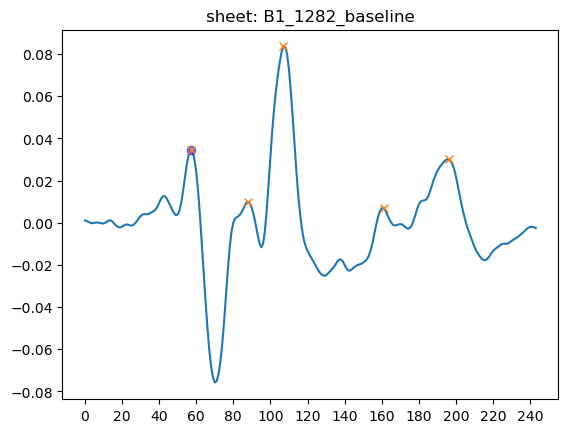

[ 56  82 107 163 199]
Metrics for sheet B2_1288_baseline:
Latency: 56 points
Curvature: -0.00010699999999999946
W1/W4 Ratio: 0.8475033051967864

None


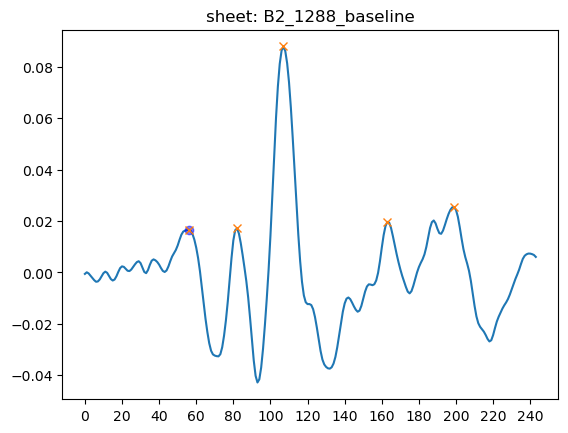

[ 55  84 110 135 209]
Metrics for sheet B2_1289_baseline:
Latency: 55 points
Curvature: 0.0004999999999999996
W1/W4 Ratio: 0.7058823529411764

None


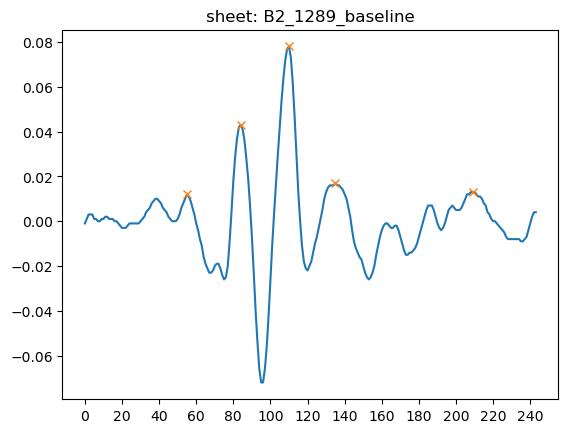

[ 56  84 108 159 200]
Metrics for sheet A1_1293_24h PSI:
Latency: 56 points
Curvature: -0.0005000000000000004
W1/W4 Ratio: 2.0

None


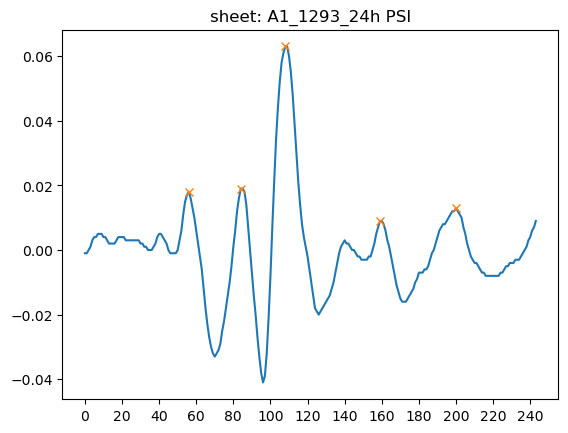

[ 48  81 108 133 163]
Metrics for sheet B2_1291_baseline:
Latency: 48 points
Curvature: 0.0
W1/W4 Ratio: 1.4999999999999998

None


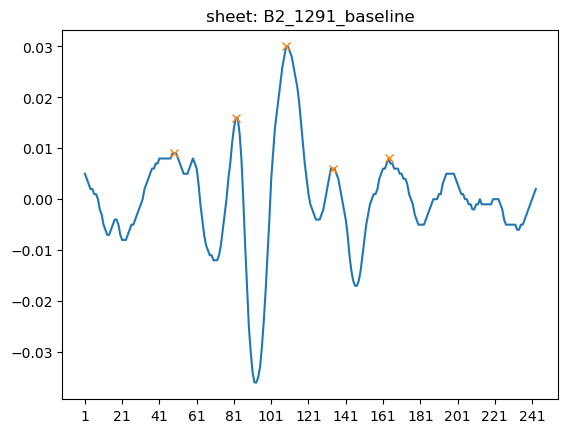

[ 52 102 125 173 188]
Metrics for sheet B2_1283_baseline:
Latency: 52 points
Curvature: -0.00036000000000000094
W1/W4 Ratio: 1.7272507260406582

None


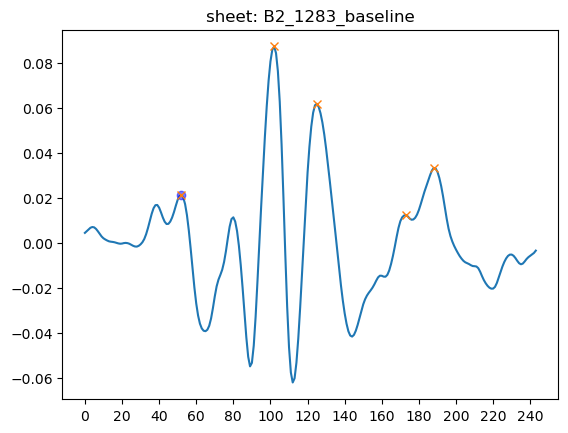

[ 34  62  86 117 173]
Metrics for sheet B2_1290_baseline:
Latency: 34 points
Curvature: 0.0
W1/W4 Ratio: 0.2105263157894737

None


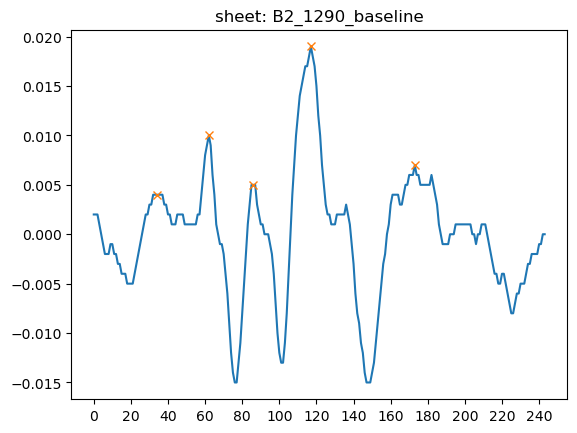

[ 52  77 102 151 186]
Metrics for sheet B2_1292_baseline:
Latency: 52 points
Curvature: 0.001
W1/W4 Ratio: 1.0833333333333333

None


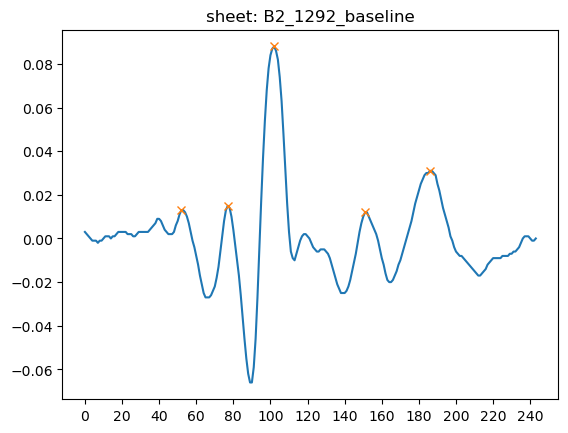

[ 62  85 112 170 203]
Metrics for sheet A1_1295_24h VEH:
Latency: 62 points
Curvature: 0.0
W1/W4 Ratio: 1.0714285714285714

None


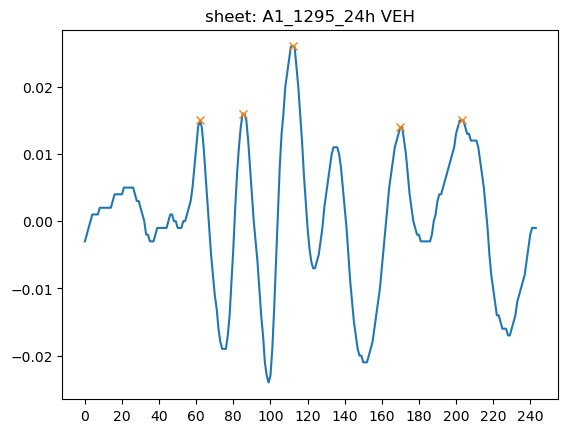

[ 59  83 110 145 196]
Metrics for sheet A1_1294_24h PSI:
Latency: 59 points
Curvature: -0.0005000000000000004
W1/W4 Ratio: 1.5806451612903227

None


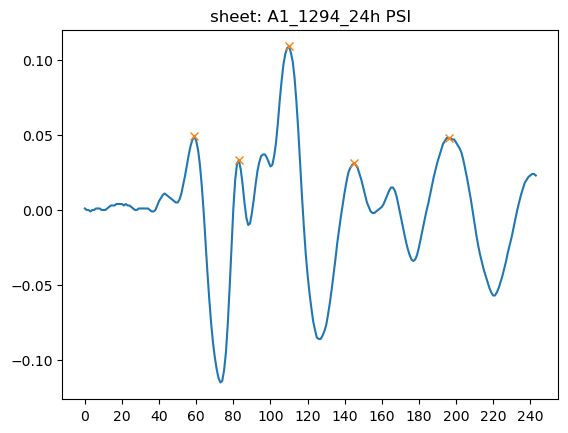

[ 40  90 115 145 234]
Metrics for sheet A1_1296_24h VEH:
Latency: 40 points
Curvature: 0.0
W1/W4 Ratio: 0.15789473684210528

None


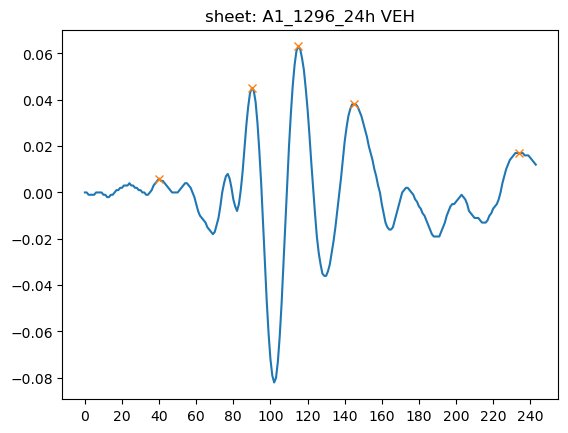

In [43]:
calculate_and_plot_metrics()